<a href="https://colab.research.google.com/github/johnhallman/tigercontrol/blob/tutorials/tutorials/notebooks/Custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom models and problems

In order to add a new algorithm to the registry, you must first implement a CustomModel object that adheres to the specifications of the other TigerControl models. As long as your class inherits the tigercontrol CustomClass object and has the three core TigerControl Model methods implemented — *initialize*, *predict*, and *update* — the class will interface as expected with all the other features in the framework. These methods are:

*   Initialize — initializes model parameters and other local variables, and is called at the beginning of every problem run.
*   Predict — a function that takes an input observation 'x' and returns a prediction which can depend on the parameters defined in initialize.
*   Update — which takes the true label with respect to the last observed value 'x' and performs some correction over the initialized parameters.

In this notebook, we demonstrate how to implement and add your own models to TigerControl. We start as usual by installing the package.


In [0]:
!git clone https://github.com/johnhallman/tigercontrol.git
!pip install -e tigercontrol

In [0]:
import tigercontrol
import jax
import jax.numpy as np
import jax.random as random
from tigercontrol.utils import generate_key
import matplotlib.pyplot as plt
tigercontrol.set_key(1)

Below, we implement the most trivial model possible, with no initialize or update and with a predict method which returns the previously observed value.

In [0]:
class TrivialModel(tigercontrol.CustomModel):
  
  def initialize(self):
    pass
  
  def predict(self, x):
    return x
  
  def update(self, y_true):
    pass

TigerControl comes with a built in ```register_custom_model``` method that allows users to register model classes with custom names.

In [0]:
tigercontrol.register_custom_model(TrivialModel, "TrivialModel")

Next, we demonstrate how to implement and register a recurrent neural network (RNN) using JAX and the existing Adagrad optimizer. In order to use the existing TigerControl optimizers, the custom class needs to provide a method which takes parameters $\theta$ and input $x$ and maps them to a prediction using solely JAX and regular arithmetic API. 

Because TigerControl models are provided only with the most recent observation as input for predict, and because RNNs need to take a history of observations in order to make predictions, we need to implement a private helper method to support RNN's predict. In the code below, we will call this private method \_predict, which takes parameters $\theta$ in the form of a list of matrices, and $x$ which is a list of the previous $k$ observations $x_t$.

In [0]:
# get glorot initialization from JAX
import jax.experimental.stax as stax 
glorot_init = stax.glorot()

class MyRNN(tigercontrol.CustomModel):
  # input_dim: dimension of RNN inputs, hidden_dim: dimension of hidden state/output
  # memory_length: length of observation history to store
  # optimizer: TigerControl optimizer class or instance (used in update method)
  def initialize(self, input_dim, hidden_dim, memory_length, optimizer):
    
    # store arguments
    self.d_in = input_dim
    self.d_hid = hidden_dim
    self.mem = memory_length
    self.x_history = np.zeros((memory_length, input_dim))
    
    # initialize and store model parameters
    W_h = glorot_init(generate_key(), (hidden_dim, hidden_dim))
    W_x = glorot_init(generate_key(), (hidden_dim, input_dim))
    b = random.normal(generate_key(), shape=(hidden_dim,))
    self.params = [W_h, W_x, b]
    
    # initialize predict helper method (x is a history in this case)
    def _predict(params, x): 
      W_h, W_x, b = params      # unroll parameters
      hid = np.zeros(hidden_dim)
      for x_t in x:
        hid = np.tanh(np.dot(W_h, hid) + np.dot(W_x, x_t) + b)
      return hid
    self._predict = jax.jit(_predict)   # jit compiles code and improves efficiency
    
    # store optimizer in method by providing helper predict
    self._store_optimizer(optimizer, self._predict)
    
  # x is an input_dim length ndarray
  def predict(self, x):
    
    # store new observation in history
    temp = np.roll(self.x_history, self.d_in)
    self.x_history = jax.ops.index_update(temp, jax.ops.index[0,:], x)
    
    # return prediction via helper method
    return self._predict(self.params, self.x_history)

  
  # y_true is the next observation/label
  def update(self, y):
    self.params = self.optimizer.update(self.params, self.x_history, y)
    return

Every TigerControl model, including those inheriting the CustomModel class, come with a built-in \_store\_optimizer method which can be called to load the optimizer into the model. Optimizers as well as \_store\_optimizer must take a prediction method in order to be able to compute gradients to optimize against, and because optimizers depend on JAX's autograd functionality, any predict method passed to an optimizer must be implemented using JAX NumPy.

We now register and run our model on an ARMA(5, 3) problem and compare it's performance to LastValue.

In [0]:
from tigercontrol.models.optimizers import Adagrad, mse

# register and initialize custom RNN model
tigercontrol.register_custom_model(MyRNN, "MyRNN")
my_model = tigercontrol.model("MyRNN")
d_in, d_hid, memory = 1, 1, 6
optimizer = Adagrad(learning_rate=0.01)
my_model.initialize(d_in, d_hid, memory, optimizer)

Once our model has been initialized, we now run the comparison against the LastValue model.

In [0]:
# initialize LastValue model and ARMA problem
pz_model = tigercontrol.model("LastValue")
pz_model.initialize()

T = 2500
p, q = 5, 3
problem = tigercontrol.problem("ARMA-v0")
x = problem.initialize(p, q)

# run comparison
my_results = []
pz_results = []
for i in range(T):
    my_y_pred = my_model.predict(x)
    pz_y_pred = pz_model.predict(x)
    y_true = problem.step()
    my_loss = mse(y_true, my_y_pred)
    pz_loss = mse(y_true, pz_y_pred)
    my_results.append(my_loss)
    pz_results.append(pz_loss)
    my_model.update(y_true)
    pz_model.update(y_true)
    x = y_true

Finally, we plot the results of our comparison

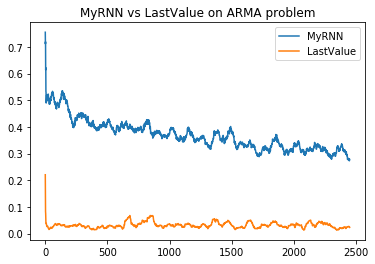

In [36]:
def smoothen(data, k=50):
  return [np.sum(data[i:i+k])/k for i in range(len(data) - k)]

# plot model performance
plt.plot(smoothen(my_results), label="MyRNN")
plt.plot(smoothen(pz_results), label="LastValue")
plt.legend()
plt.title("MyRNN vs LastValue on ARMA problem")
plt.show()

As we can see, LastValue performs better than the RNN, whereas the RNN improves over time due to the optimizer.